### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("processed_train.csv")

In [3]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [4]:
data.shape

(119952, 79)

Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [5]:
### Your code is here

data['HasDetections'].value_counts()



0    99940
1    20012
Name: HasDetections, dtype: int64

Произведем процедуру отложенной выборки:

In [6]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [7]:
### Your code is here
### создадим pipe с масштабированием данных и LR , укажем регуляризацию l2 с параметром C = 0.01
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('LR', LogisticRegression(penalty='l2', C = 0.01))
                ])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR', LogisticRegression(C=0.01))])

In [8]:
### Pipeline автоматом для классификации отображает accuracy
print(f"{np.round(pipe.score(X_train, y_train),3)} {np.round(pipe.score(X_test, y_test),3)}")

0.841 0.842


In [9]:
# проверим на всякий случай на кросс-валидации
from sklearn.model_selection import cross_validate
import datetime

custom_cv = [(X_train.index.to_list(), X_test.index.to_list())]

begin_time = datetime.datetime.now()

cv_result_pipe = cross_validate(pipe, X, y, scoring='accuracy',
                                cv=custom_cv, return_train_score=True)


print(f"Accuracy на трейне: {np.mean(cv_result_pipe['train_score']).round(3)}")
print(f"Accuracy на тесте: {np.mean(cv_result_pipe['test_score']).round(3)}")

print(f"Время работы алгоритма: {datetime.datetime.now() - begin_time}")

Accuracy на трейне: 0.841
Accuracy на тесте: 0.842
Время работы алгоритма: 0:00:01.365008


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [10]:
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)

### Your code is here


In [11]:
from sklearn.metrics import confusion_matrix

### Your code is here

true_negative, false_positive, false_negative, true_positive = \
                                                            confusion_matrix(y_test, pred_test).ravel()
print(f"TN, FP, FN, TP : {true_negative}, {false_positive}, {false_negative}, {true_positive} ")


TN, FP, FN, TP : 24726, 293, 4442, 527 


**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [12]:
### Your code is here

acc = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

print(f"Accuracy на тестовой выборке : {np.round(acc,3)}")

Accuracy на тестовой выборке : 0.842


Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [13]:
### Your code is here
### Посчитаем Precision и Recall вручную

pr = true_positive / (true_positive + false_positive)
rc = true_positive / (true_positive + false_negative)

print(f"Precision, Recall (manual calc): : {np.round(pr,3)}, {np.round(rc,3)}")

Precision, Recall (manual calc): : 0.643, 0.106


In [14]:
### теперь посчитаем метрики с помощью библиотеки sklearn
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

print(f"Precision, Recall (lib calc): {precision_score(y_test, pred_test):.3f}, {recall_score(y_test, pred_test):.3f}")
print(f"Accuracy_score, f1_score (lib calc): {accuracy_score(y_test, pred_test):.3f}, {f1_score(y_test, pred_test):.3f}")


Precision, Recall (lib calc): 0.643, 0.106
Accuracy_score, f1_score (lib calc): 0.842, 0.182


Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [15]:
### Your code is here
from sklearn.metrics import precision_recall_curve
precision_recall_curve(y_test, pipe.predict_proba(X_test)[: ,1])

(array([0.16569961, 0.16570514, 0.16571066, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        4.02495472e-04, 2.01247736e-04, 0.00000000e+00]),
 array([7.69747868e-05, 7.99610592e-04, 1.34767986e-03, ...,
        8.99022118e-01, 9.13112457e-01, 9.17033067e-01]))

**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [16]:
from sklearn.metrics import precision_recall_curve

pred_probs = pipe.predict_proba(X_test)
### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(y_test, pred_probs[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6

ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]:.3f}")
print(f"Recall: \t {recall[ind][-1]:.3f}")
print(f"Threshold:\t {thres[ind][-1]:.3f}")

Precison:	 0.600
Recall: 	 0.130
Threshold:	 0.458


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [18]:
### Your code is here
ind = np.where(precision == precision[recall > 0.2].max())

print(f"Precison:\t {precision[ind][-1]:.3f}")
print(f"Recall: \t {recall[ind][-1]:.3f}")
print(f"Threshold:\t {thres[ind][-1]:.3f}")

Precison:	 0.492
Recall: 	 0.200
Threshold:	 0.331


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [19]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

Precision:	 0.16995681677976557
Recall: 	 0.9979875226403703
Threshold:	 0.02198734808676978


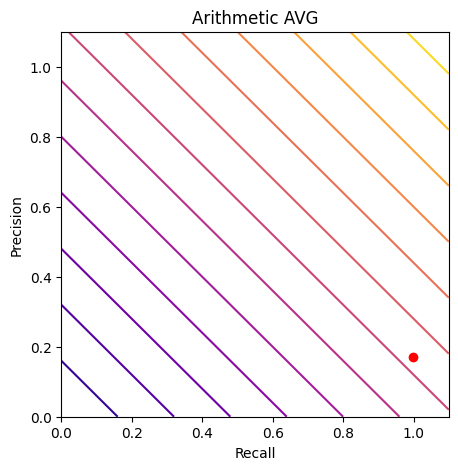

In [30]:
### Покажем на примере среднего арифметического, что должно у вас получиться

metric_func = lambda x, y: (x + y)/2

arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precision:\t {precision[arithm_idx]}")
print(f"Recall: \t {recall[arithm_idx]}")
print(f"Threshold:\t {thres[arithm_idx]}")

level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

thres, precision, recall : 0.125, 0.223, 0.812


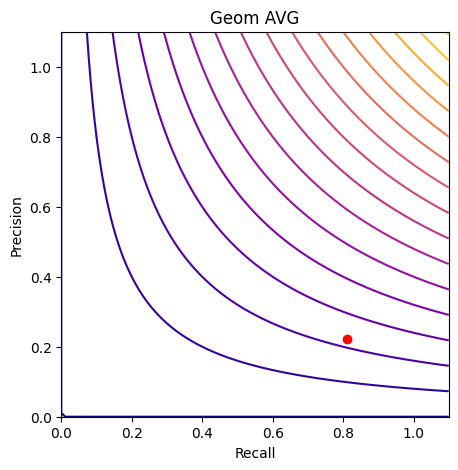

In [82]:
### Повторите для среднего геометрического
### Your code is here

metric_func_geom = lambda x, y: (x * y) ** 1/2
geom_idx = (metric_func_geom(precision, recall)).argmax()
print(f"thres, precision, recall: {thres[geom_idx]:.3f}, {precision[geom_idx]:.3f}, {recall[geom_idx]:.3f}")

level_lines(metric_func_geom, "Geom AVG")
plt.plot(recall[geom_idx], precision[geom_idx], 'ro');


thres, precision, recall: 0.237, 0.359, 0.359


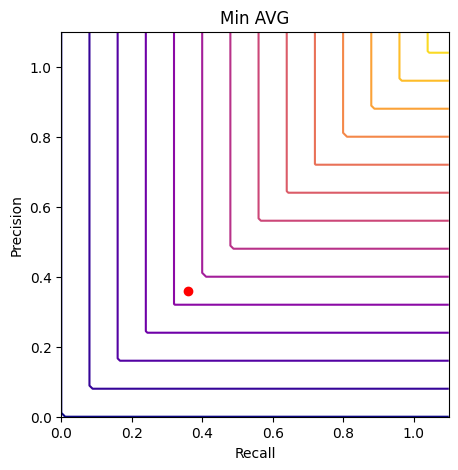

In [86]:
### Повторите для минимума
### Your code is here

metric_func_min = lambda x, y: np.minimum(x, y)

min_idx = (metric_func_min(precision, recall)).argmax()
print(f"thres, precision, recall: {np.round(thres[min_idx],3)}, {np.round(precision[min_idx],3)}, {np.round(recall[min_idx],3)}")

level_lines(metric_func_min, "Min AVG")
plt.plot(recall[min_idx], precision[min_idx], 'ro');


**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

In [173]:
def level_lines_2(func, name, b):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(b, X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

thres, precision, recall, f-мера: 0.192, 0.285, 0.525, 0.369


/tmp/ipykernel_6822/2166214877.py:5: RuntimeWarning: invalid value encountered in divide
  metric_f = lambda b, x, y: (1 + b) * x * y / (x + y)


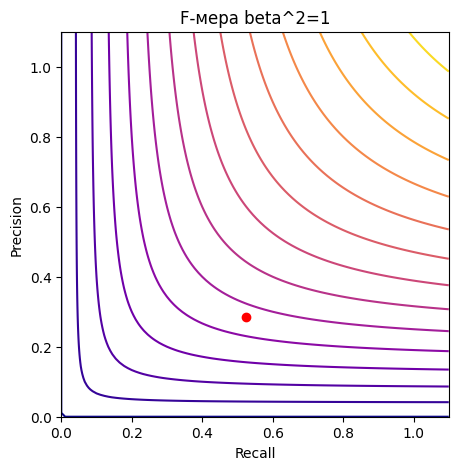

In [176]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold
### Your code is here
b = 1
metric_f = lambda b, x, y: (1 + b) * x * y / (x + y)
f1_scores = (metric_f(1, precision, recall)).argmax()
print("thres, precision, recall, f-мера: "\
f"{thres[f1_scores]:.3f}, {precision[f1_scores]:.3f}, {recall[f1_scores]:.3f}, {np.max(metric_f(1, precision, recall)):.3f}")

level_lines_2(metric_f, "F-мера beta^2=1", b)
plt.plot(recall[f1_scores], precision[f1_scores], 'ro');

thres, precision, recall, f-мера: 0.497, 0.642, 0.109, 0.521


/tmp/ipykernel_6822/1536205826.py:5: RuntimeWarning: invalid value encountered in divide
  metric_f_2 = lambda b, x, y: ((1 + b) * x * y) / ((b * x) + y)


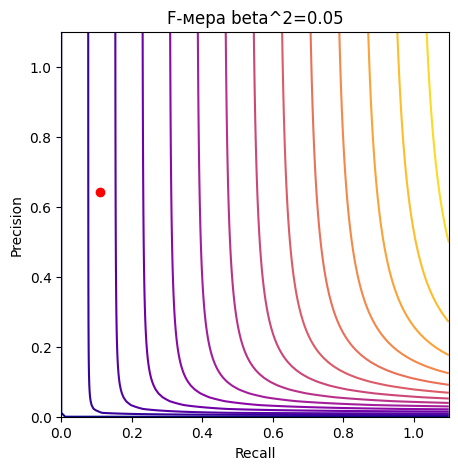

In [177]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here
b = 0.05
metric_f_2 = lambda b, x, y: ((1 + b) * x * y) / ((b * x) + y)
f2_scores = (metric_f_2(0.05, precision, recall)).argmax()
print("thres, precision, recall, f-мера: "\
f"{thres[f2_scores]:.3f}, {precision[f2_scores]:.3f}, {recall[f2_scores]:.3f}, {np.max(metric_f_2(0.05, precision, recall)):.3f}")

level_lines_2(metric_f_2, "F-мера beta^2=0.05", b)
plt.plot(recall[f2_scores], precision[f2_scores], 'ro');

thres, precision, recall, f-мера: 0.108, 0.210, 0.863, 0.532


/tmp/ipykernel_6822/2592128488.py:5: RuntimeWarning: invalid value encountered in divide
  metric_f_3 = lambda b, x, y: ((1 + b) * x * y) / ((b * x) + y)


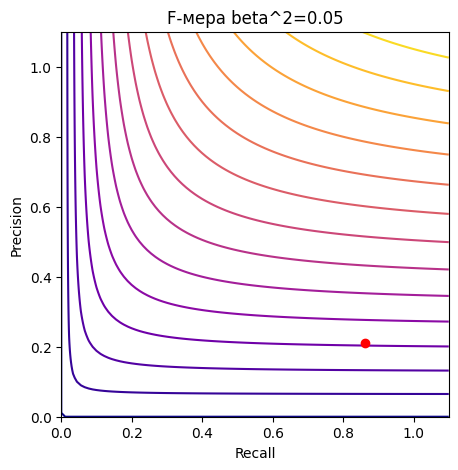

In [178]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here
b = 4
metric_f_3 = lambda b, x, y: ((1 + b) * x * y) / ((b * x) + y)
f3_scores = (metric_f_3(4, precision, recall)).argmax()
print("thres, precision, recall, f-мера: "\
f"{thres[f3_scores]:.3f}, {precision[f3_scores]:.3f}, {recall[f3_scores]:.3f}, {np.max(metric_f_3(4, precision, recall)):.3f}")

level_lines_2(metric_f_3, "F-мера beta^2=0.05", b)
plt.plot(recall[f3_scores], precision[f3_scores], 'ro');
